In [19]:
%reload_ext autoreload
%autoreload 2

import os
import sys

import boto3
import sagemaker
from sagemaker.tensorflow.estimator import TensorFlow
from sagemaker.tuner import (
    ContinuousParameter,
    IntegerParameter,
    CategoricalParameter,
    HyperparameterTuner,
)

import numpy as np
import pandas as pd
from hydra import compose, initialize, core
from omegaconf import OmegaConf

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # Nopep8
import tensorflow as tf

import matplotlib.pyplot as plt

sys.path.append(os.path.dirname(os.getcwd()))
from src.model_utils import pretty_print_code, load_datasets

## Hydra

In [2]:
core.global_hydra.GlobalHydra.instance().clear()
initialize(
    version_base="1.2", config_path="../src/config", job_name="insect_classification"
)
config = OmegaConf.to_container(compose(config_name="main"), resolve=True)

## S3

In [3]:
s3 = boto3.client("s3")

train_val_path = {
    "train": f's3://{config["s3_bucket"]}/{config["s3_key"]}/input-data/train',
    "val": f's3://{config["s3_bucket"]}/{config["s3_key"]}/input-data/val',
}
train_val_path

{'train': 's3://yang-ml-sagemaker/insect-pest-classification/input-data/train',
 'val': 's3://yang-ml-sagemaker/insect-pest-classification/input-data/val'}

Read in test set for inference:

In [ ]:
test_dataset = load_datasets(
    dir=f's3://{config["s3_bucket"]}/{config["s3_key"]}/input-data/test',
    batch_size=config["batch_size"],
    val=False,
)

## SageMaker

In [4]:
sagemaker_session = sagemaker.Session(default_bucket=config["s3_bucket"])
sm_boto3 = boto3.client("sagemaker")
role = sagemaker.get_execution_role()

## Insect Classification

### Data Preprocessing

The data ingestion script is as follows:

* We create a `downsample` function that will first count the number of files in the subdirectories--- train, val, test, which represent the number of samples for the classes. 
  Next, for classes with more than `max_samples` samples, it will randomly remove files until the number of samples is equal to `max_samples`, which we set to 200. In other words, each class has at *most* 200 training examples.

* Preprocessing steps such as data augmentation and scaling will be included in the training scripts below.

* Finally, we upload the `tf.data.Dataset` objects directly to S3, which utilizes the `tensorflow_io` extension package. 

Here is the main program for data ingestion:

In [12]:
ingestion_script = os.path.join(os.path.dirname(os.getcwd()), "src/ingest_upload.py")
pretty_print_code(ingestion_script)

2023-07-28 08:23:51,537 INFO data_ingest: Downloading and unzipping raw data zip file from s3...
download: s3://yang-ml-sagemaker/insect-pest-classification/raw-data/data.zip to ../src/data/data.zip
2023-07-28 08:24:57,742 INFO data_ingest: Downsampling data...
Found 17633 files belonging to 102 classes.
2023-07-28 08:25:00,906 INFO data_ingest: Saving train data to s3...


2023-07-28 08:25:00.785009: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Found 6288 files belonging to 102 classes.
2023-07-28 08:26:05,909 INFO data_ingest: Saving val data to s3...
Found 13725 files belonging to 102 classes.
2023-07-28 08:26:23,625 INFO data_ingest: Saving test data to s3...
2023-07-28 08:27:11,518 INFO data_ingest: Plotting class distributions...


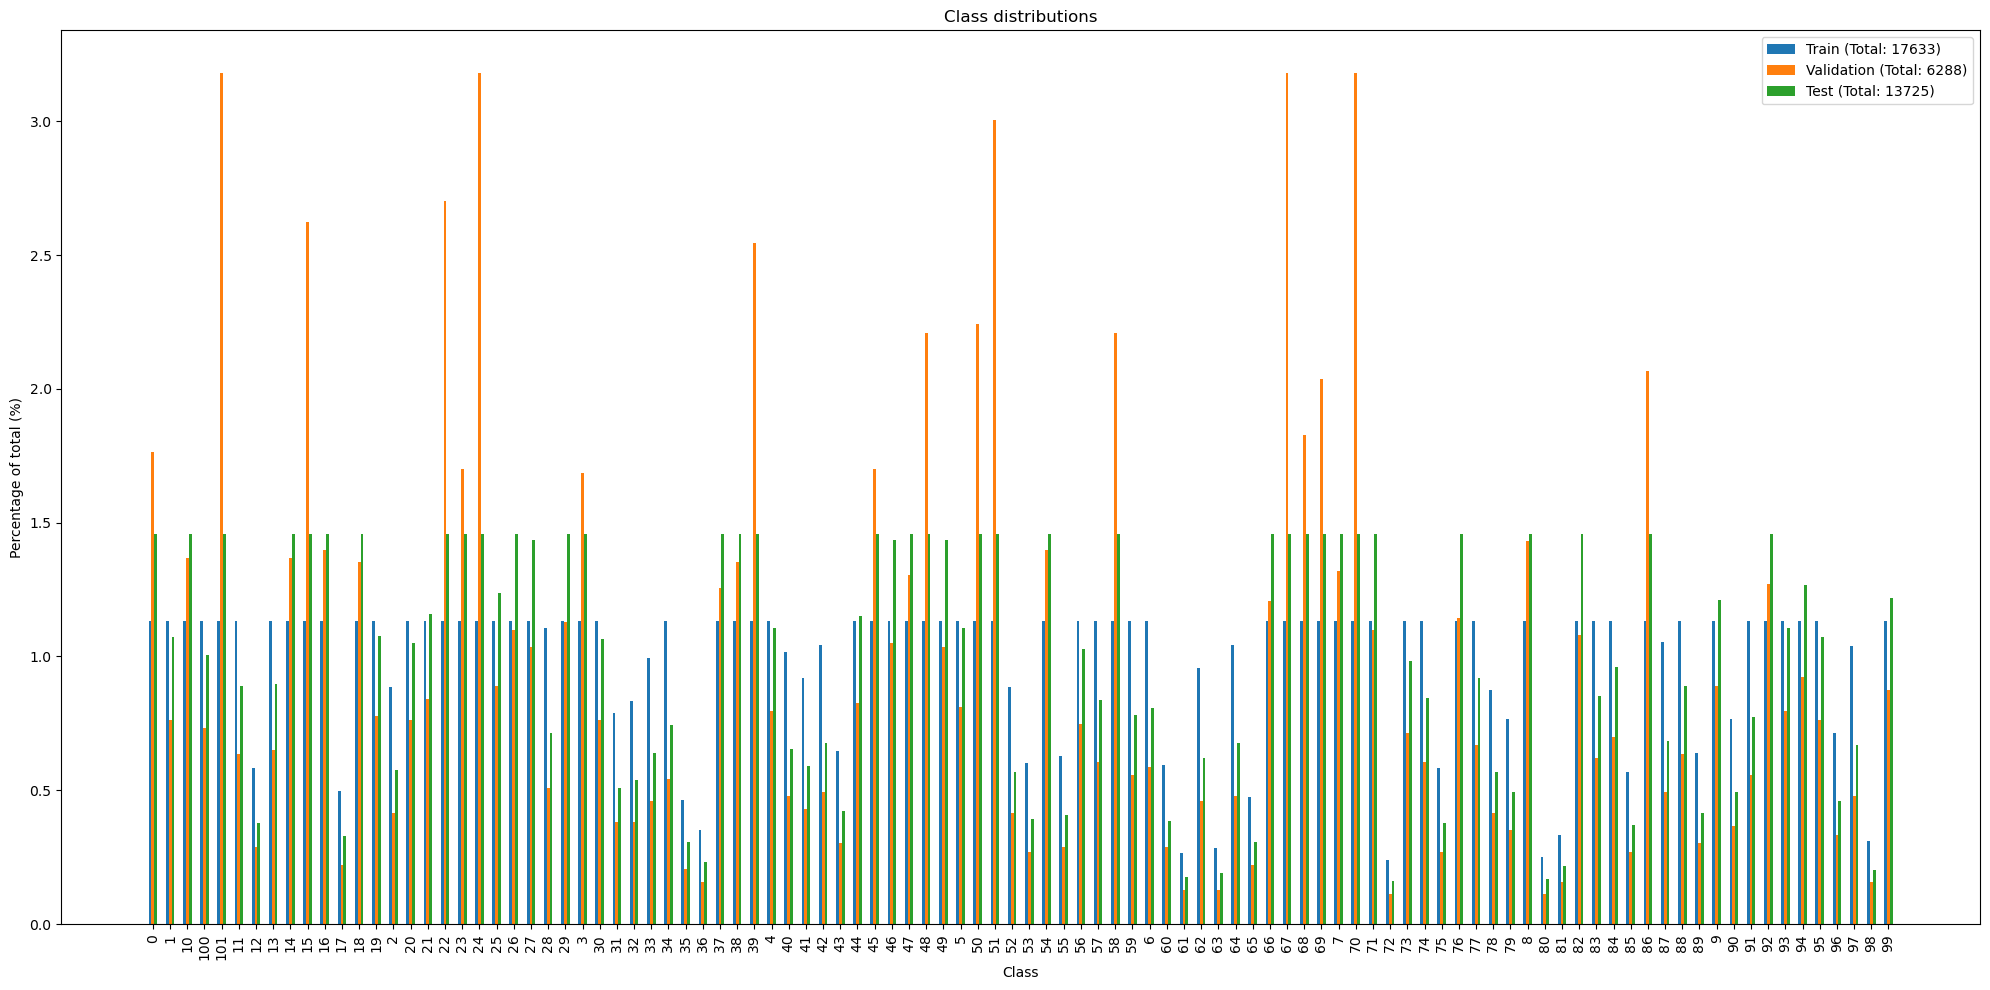

2023-07-28 08:27:13,101 INFO data_ingest: Cleaning up by removing raw data zip file and unzipped data...


In [7]:
%run {ingestion_script}

As can be seen, the datasets are imbalanced. The subsampling created an artificial ceiling (in terms of the maximum number of samples per class), which can be removed with more computational resources. Unfortunately, tensorflow 2.13.0 is not availabe with sagemaker SDK at the time of writing this, so we cannot take advantage of the newly implemented multi-class [focal loss](https://arxiv.org/abs/1708.02002) function. Nevertheless, we will use class weights to try to combat the class imbalance issue.

### Custom Baseline Model 

The entry point script includes the following:

* Data augmentation: random rotation and random contrast

* Batch normalization, pooling, l2 regularization for convolutional dense layers and dropout for dense layers only

* Early stopping with `patience=3`, monitoring the categorical cross-entropoy loss on the validation set

* Performance metrics: accruacy, precision, recall, and aucpr

We utilize distributed training, which creates copies of all variables in the CNN's layers on each device (GPU) across all workers (EC2 instances). The tensorflow implementation uses collective operations to aggregate gradients and keeps the variables in sync across all devices and workers. For each training job, we use two `ml.p3.8xlarge` instances each with four GPUs.

In [13]:
# Main program
baseline_entry = os.path.join(os.path.dirname(os.getcwd()), "src/baseline_entry.py")

pretty_print_code(baseline_entry)

#### Tensorflow Estimator

First, we test the training script locally on CPU:

In [267]:
test_estimator = TensorFlow(
    entry_point=config["baseline"]["entry_point"],
    source_dir=config["src_dir_path"],
    role=role,
    py_version=config["baseline"]["py_version"],
    framework_version=config["baseline"]["framework_version"],
    model_dir=config["model_dir"],
    code_location=config["code_location"],
    output_path=config["output_path"],
    instance_type="local",
    instance_count=1,
    hyperparameters={
        "test_mode": 1,
        "use_focal_loss": 0,
        # Test with fixed hyperparameters
        "conv2d_num_filters_block_0": 8,
        "conv2d_num_filters_block_1": 8,
        "conv2d_num_filters_block_2": 8,
        "conv2d_num_filters_block_3": 8,
        "conv2d_num_filters_block_4": 8,
        "dense_num_units_0": 8,
        "dense_num_units_1": 8,
        "dense_num_units_2": 8,
        "loss_alpha": 0.25,
        "loss_gamma": 2.0,
        "conv2d_pooling_size": 2,
        "conv2d_kernel_size": 3,
        "dense_dropout_rate": 0.5,
        "opt_learning_rate": 0.001,
        "opt_adam_beta_1": 0.9,
        "opt_adam_beta_2": 0.999,
        "opt_clipnorm": 1.0,
        "fit_epochs": 1,
    },
)

test_estimator

In case we need to run the test multiple times when debugging, we have to clear the tmp directory every now and then since this is where the local test mode writes to:

In [268]:
!sudo rm -rf /tmp/tmp*

In [ ]:
test_estimator.fit(train_val_path)

Re-instantiate estimator for cloud training:

In [6]:
baseline_estimator = TensorFlow(
    # Entry point
    entry_point=config["baseline"]["entry_point"],
    source_dir=config["src_dir_path"],
    py_version=config["baseline"]["py_version"],
    framework_version=config["baseline"]["framework_version"],
    # Sagemaker
    role=role,
    instance_type=config["baseline"]["instance_type"],
    instance_count=config["baseline"]["instance_count"],
    model_dir=config["model_dir"],
    code_location=config["code_location"],
    output_path=config["output_path"],
    volume_size=config["volume_size"],
    base_job_name=config["baseline"]["base_job_name"],
    sagemaker_session=sagemaker_session,
    # Distributed
    distribution={"multi_worker_mirrored_strategy": {"enabled": True}},
    # Spot training
    max_run=config["max_run"],
    max_wait=config["max_run"],  # Equal or greater than max_run
    max_retry_attempts=config["max_retry_attempts"],
    use_spot_instances=config["use_spot_instances"],
    checkpoint_s3_uri=os.path.join(config["checkpoint_s3_uri"], "baseline"),
    # Fixed hyperparameters
    hyperparameters={"test_mode": 0, "use_focal_loss": 0},
)

baseline_estimator

#### Hyperparameter Tuning

For hyperparamter tuning, we use Bayesian optimization with a limited budget (10 trials):

In [7]:
baseline_search_space = {
    # Convolutional
    "conv2d_num_filters_block_0": IntegerParameter(32, 64),
    "conv2d_num_filters_block_1": IntegerParameter(64, 128),
    "conv2d_num_filters_block_2": IntegerParameter(64, 256),
    "conv2d_num_filters_block_3": IntegerParameter(128, 256),
    "conv2d_num_filters_block_4": IntegerParameter(128, 256),
    "conv2d_pooling_size": IntegerParameter(2, 3),
    "conv2d_kernel_size": IntegerParameter(2, 3),
    # Fully-connected
    "dense_num_units_0": IntegerParameter(64, 256),
    "dense_num_units_1": IntegerParameter(64, 256),
    "dense_num_units_2": IntegerParameter(64, 512),
    "dense_dropout_rate": ContinuousParameter(0.3, 0.5),
    # Loss function hyperparameters if use_focal_loss = 1
    "loss_alpha": ContinuousParameter(0.1, 0.9),
    "loss_gamma": ContinuousParameter(0.5, 2.0),
    # Optimizer
    "opt_learning_rate": ContinuousParameter(1e-6, 1e-1, scaling_type="Logarithmic"),
    "opt_adam_beta_1": ContinuousParameter(0.6, 0.999),
    "opt_adam_beta_2": ContinuousParameter(0.8, 0.999),
    "opt_clipnorm": ContinuousParameter(1e-2, 1.0),
    "fit_epochs": IntegerParameter(5, 10),
}

# Minimize categorical cross-entropy loss
baseline_objective_metric_name = "loss"
baseline_objective_type = "Minimize"
baseline_metric_definitions = [
    {
        "Name": baseline_objective_metric_name,
        "Regex": "Best validation loss: ([0-9\\.]+)",
    }
]

In [8]:
baseline_tuner = HyperparameterTuner(
    estimator=baseline_estimator,
    objective_metric_name=baseline_objective_metric_name,
    hyperparameter_ranges=baseline_search_space,
    metric_definitions=baseline_metric_definitions,
    strategy="Bayesian",
    objective_type=baseline_objective_type,
    max_jobs=10,
    max_parallel_jobs=5,
    base_tuning_job_name=config["baseline"]["base_job_name"],
)

In [ ]:
baseline_tuner.fit(train_val_path)

To visualize the results of the hyperparameter optimization:

In [22]:
baseline_hpo = sagemaker.HyperparameterTuningJobAnalytics(
    baseline_tuner.latest_tuning_job.name
)

baseline_hpo_results = baseline_hpo.dataframe()

baseline_hpo_results.dropna(inplace=True)

baseline_hpo_results.sort_values("FinalObjectiveValue", ascending=True)

,conv2d_kernel_size,conv2d_num_filters_block_0,conv2d_num_filters_block_1,conv2d_num_filters_block_2,conv2d_num_filters_block_3,conv2d_num_filters_block_4,conv2d_pooling_size,dense_dropout_rate,dense_num_units_0,dense_num_units_1,...,opt_adam_beta_1,opt_adam_beta_2,opt_clipnorm,opt_learning_rate,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
5,3.0,60.0,70.0,102.0,202.0,134.0,3.0,0.482106,183.0,96.0,...,0.991064,0.992042,0.023997,0.026381,baseline-training-230729-0310-005-ee2a4e20,Completed,4.640457,2023-07-29 03:13:04+00:00,2023-07-29 03:22:34+00:00,570.0
0,3.0,64.0,82.0,64.0,236.0,128.0,3.0,0.303428,201.0,227.0,...,0.945642,0.998231,0.010000,0.000006,baseline-training-230729-0310-010-97718e83,Completed,26.077307,2023-07-29 03:30:33+00:00,2023-07-29 03:37:57+00:00,444.0
6,3.0,59.0,114.0,124.0,209.0,234.0,3.0,0.353014,124.0,125.0,...,0.980321,0.828708,0.306772,0.000383,baseline-training-230729-0310-004-a56258e0,Completed,27.416353,2023-07-29 03:13:01+00:00,2023-07-29 03:25:05+00:00,724.0
2,3.0,49.0,72.0,99.0,253.0,256.0,2.0,0.314288,170.0,175.0,...,0.998806,0.975268,0.958245,0.000031,baseline-training-230729-0310-008-3816d81a,Completed,31.150431,2023-07-29 03:23:00+00:00,2023-07-29 03:32:39+00:00,579.0
8,2.0,58.0,106.0,144.0,175.0,248.0,3.0,0.383493,103.0,225.0,...,0.959099,0.884666,0.880580,0.000001,baseline-training-230729-0310-002-f239c64a,Completed,32.597595,2023-07-29 03:13:05+00:00,2023-07-29 03:21:24+00:00,499.0
4,2.0,60.0,126.0,155.0,176.0,253.0,3.0,0.364449,245.0,157.0,...,0.986428,0.997707,0.015092,0.001309,baseline-training-230729-0310-006-3abbbc68,Completed,33.902290,2023-07-29 03:21:56+00:00,2023-07-29 03:31:20+00:00,564.0
7,3.0,44.0,81.0,162.0,203.0,232.0,2.0,0.367136,95.0,184.0,...,0.967210,0.938163,0.063987,0.000005,baseline-training-230729-0310-003-84b1ddc4,Completed,34.589096,2023-07-29 03:13:00+00:00,2023-07-29 03:21:56+00:00,536.0
3,3.0,33.0,66.0,100.0,147.0,176.0,3.0,0.449202,225.0,139.0,...,0.998652,0.883908,0.026940,0.000223,baseline-training-230729-0310-007-b3d7722e,Completed,35.086231,2023-07-29 03:22:21+00:00,2023-07-29 03:29:45+00:00,444.0
1,3.0,39.0,80.0,256.0,256.0,200.0,3.0,0.500000,207.0,129.0,...,0.600000,0.999000,0.098586,0.000018,baseline-training-230729-0310-009-06454834,Completed,36.372818,2023-07-29 03:25:42+00:00,2023-07-29 03:34:36+00:00,534.0


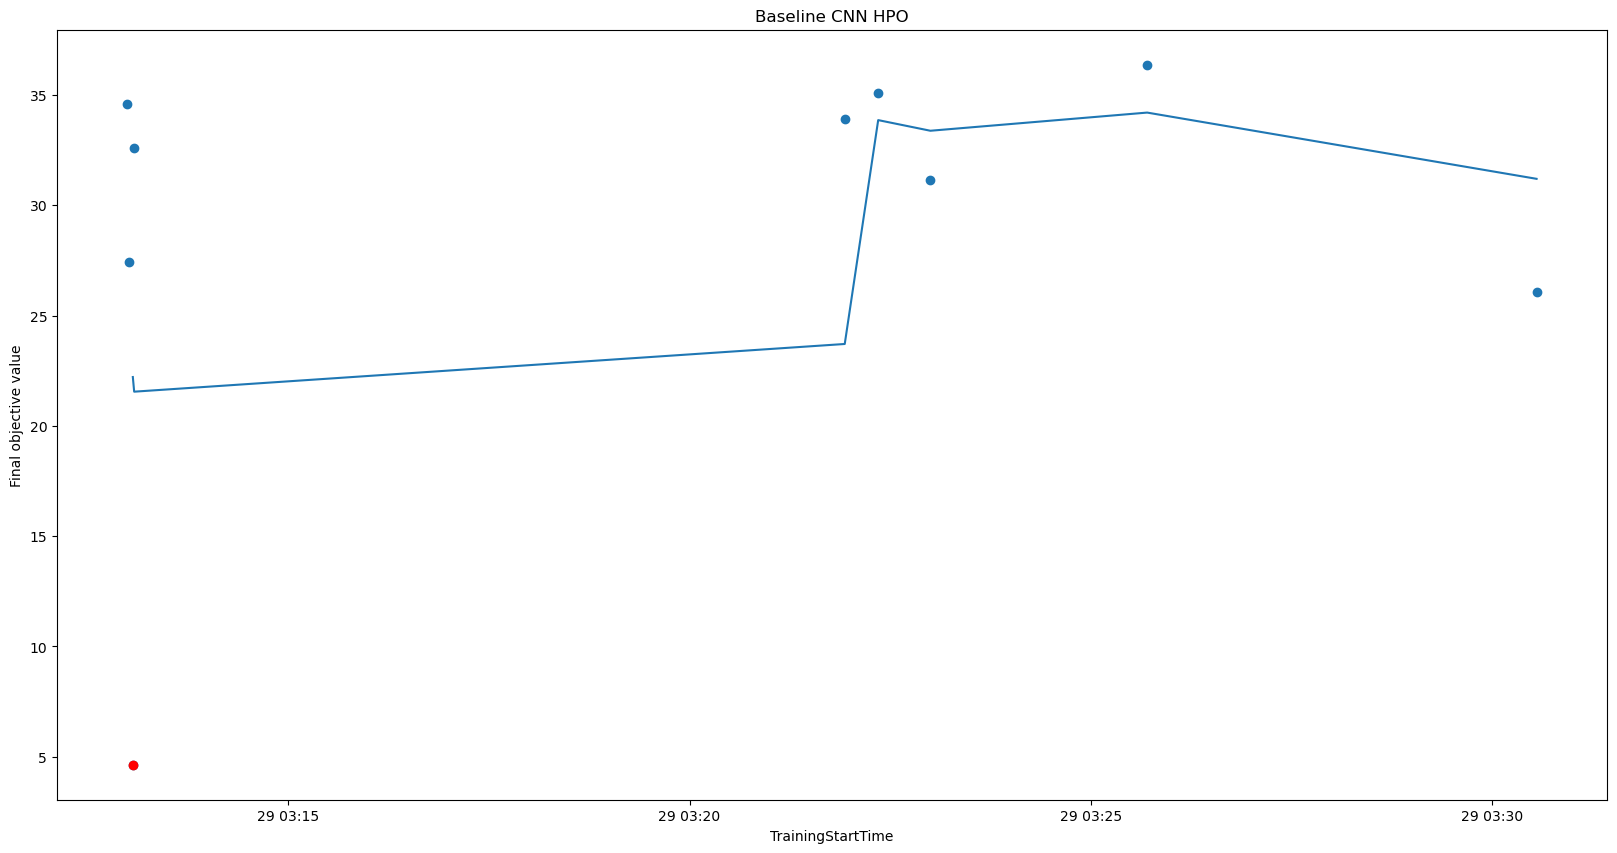

In [24]:
plt.figure(figsize=(20, 10))
# Sort by TrainingStartTime
baseline_hpo_results.sort_values("TrainingStartTime", inplace=True)
plt.scatter(
    baseline_hpo_results["TrainingStartTime"],
    baseline_hpo_results["FinalObjectiveValue"],
)
plt.plot(
    baseline_hpo_results["TrainingStartTime"],
    baseline_hpo_results["FinalObjectiveValue"].rolling(3).mean(),
)
# Highlight the best score in red
plt.scatter(
    baseline_hpo_results["TrainingStartTime"][
        baseline_hpo_results["FinalObjectiveValue"].idxmin()
    ],
    baseline_hpo_results["FinalObjectiveValue"].min(),
    c="r",
)
plt.xlabel("TrainingStartTime")
plt.ylabel("Final objective value")
plt.title("Baseline CNN HPO")
plt.show();

#### TensorBoard

We can also use Tensorboard to visualize the loss function during training:

In [33]:
tensorboard_log_dir = f's3://{config["s3_bucket"]}/{config["s3_key"]}/tensorboard_logs/{baseline_tuner.best_training_job()}'

!tensorboard --logdir $tensorboard_log_dir --host localhost --port 6006

2023-07-29 04:05:52.672056: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
TensorBoard 2.12.3 at http://localhost:6006/ (Press CTRL+C to quit)
^C


Here is a the plot of the training and validation losses over epochs:

<center>

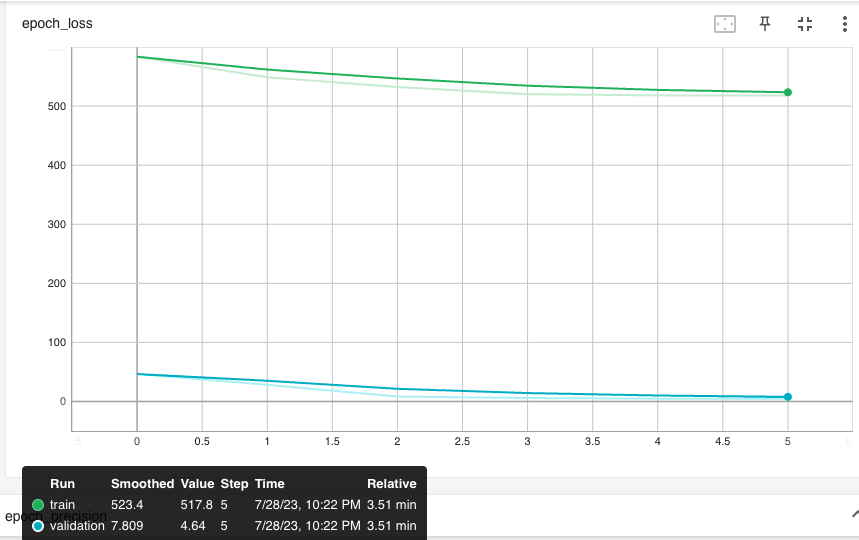

</center>

#### Summary of Model Architecture

The model architecture is as follows:

* 5 convolutional layers with batch normalization and max pooling

* 3 dense layers with batch normalization and drop-outs

* L2 regularization with both convolutional and dense layers

Normally, we deploy the best model as an endpoint for inference. But we also can load the model directly and examine the architecture:

In [35]:
# Download model gzip file
baseline_model_path = baseline_tuner.best_estimator().model_data
baseline_model_path


2023-07-29 03:22:59 Starting - Preparing the instances for training
2023-07-29 03:22:59 Downloading - Downloading input data
2023-07-29 03:22:59 Training - Training image download completed. Training in progress.
2023-07-29 03:22:59 Uploading - Uploading generated training model
2023-07-29 03:22:59 Completed - Resource reused by training job: baseline-training-230729-0310-008-3816d81a


's3://yang-ml-sagemaker/insect-pest-classification/models/baseline-training-230729-0310-005-ee2a4e20/output/model.tar.gz'

In [40]:
!aws s3 cp $baseline_model_path /tmp/baseline_model.tar.gz
!tar -xvzf /tmp/baseline_model.tar.gz -C /tmp

download: s3://yang-ml-sagemaker/insect-pest-classification/models/baseline-training-230729-0310-005-ee2a4e20/output/model.tar.gz to ../../../../../tmp/baseline_model.tar.gz
00000000/
00000000/keras_metadata.pb
00000000/saved_model.pb
00000000/fingerprint.pb
00000000/variables/
00000000/variables/variables.data-00000-of-00001
00000000/variables/variables.index
00000000/assets/


Now, we load in the model:

In [243]:
baseline_model = tf.keras.models.load_model("/tmp/00000000")
baseline_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 data_augmentation_layers (S  (None, 256, 256, 3)      0         
 equential)                                                      
                                                                 
 rescaling_layer (Rescaling)  (None, 256, 256, 3)      0         
                                                                 
 conv2d_0 (Conv2D)           (None, 256, 256, 60)      1620      
                                                                 
 conv2d_batch_norm_0 (BatchN  (None, 256, 256, 60)     240       
 ormalization)                                                   
                                                                 
 conv2d_relu_0 (Activation)  (None, 256, 256, 60)      0     

Here is a manual calculation of the total number of *trainable* parameters:

* Note that we do not use bias terms except for the last output (dense) layer because we already use batch normalization

* A batch normalization layer has *four* parameters for each channel (feature map) of its input: gamma (scale), beta (offset), mean, and variance, where the latter two are *non-trainable*

In [49]:
best_trial = baseline_hpo_results[
    baseline_hpo_results["FinalObjectiveValue"]
    == baseline_hpo_results["FinalObjectiveValue"].min()
]
best_trial

,conv2d_kernel_size,conv2d_num_filters_block_0,conv2d_num_filters_block_1,conv2d_num_filters_block_2,conv2d_num_filters_block_3,conv2d_num_filters_block_4,conv2d_pooling_size,dense_dropout_rate,dense_num_units_0,dense_num_units_1,...,opt_adam_beta_1,opt_adam_beta_2,opt_clipnorm,opt_learning_rate,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
5,3.0,60.0,70.0,102.0,202.0,134.0,3.0,0.482106,183.0,96.0,...,0.991064,0.992042,0.023997,0.026381,baseline-training-230729-0310-005-ee2a4e20,Completed,4.640457,2023-07-29 03:13:04+00:00,2023-07-29 03:22:34+00:00,570.0


For convolutional layers:

In [244]:
# Filter size (where height = width)
filter_size = best_trial["conv2d_kernel_size"].values[0]

# Depths (numbers of feature maps) outputted by each convolutional layer
depths = [
    # Input channel is 3 since we have 3 color channels
    3,
    best_trial["conv2d_num_filters_block_0"].values[0],
    best_trial["conv2d_num_filters_block_1"].values[0],
    best_trial["conv2d_num_filters_block_2"].values[0],
    best_trial["conv2d_num_filters_block_3"].values[0],
    best_trial["conv2d_num_filters_block_4"].values[0],
]

conv2d_layer_weights = []
for i in range(1, len(depths)):
    # Formula: filter_height * filter_width * input_channels * output_channels
    conv_2d_params = filter_size * filter_size * depths[i - 1] * depths[i]
    batch_norm_params = 2 * depths[i]
    conv2d_layer_weights.append(conv_2d_params + batch_norm_params)

conv2d_layer_weights

[1740.0, 37940.0, 64464.0, 185840.0, 243880.0]

For dense layers:

In [245]:
dense_units = [
    best_trial["dense_num_units_0"].values[0],
    best_trial["dense_num_units_1"].values[0],
    best_trial["dense_num_units_2"].values[0],
]

dense_layer_weights = []
for i in range(len(dense_units)):
    # The number of units of the first dense layer must be multiplied with number of feature maps outputted by the last convolutional layer
    if i == 0:
        dense_params = depths[-1] * dense_units[i]
        batch_norm_params = 2 * dense_units[i]
        dense_layer_weights.append(dense_params + batch_norm_params)
    else:
        dense_params = dense_units[i - 1] * dense_units[i]
        batch_norm_params = 2 * dense_units[i]
        dense_layer_weights.append(dense_params + batch_norm_params)
# Add output layer, including biases for each of the units (102 classes)
dense_layer_weights.append(dense_units[-1] * 102 + (102 * 1))
dense_layer_weights

[24888.0, 17760.0, 14210.0, 14892.0]

Summing all the above:

In [246]:
print(f"Number of parameters in convolutional layers: {int(sum(conv2d_layer_weights))}")
print(f"Number of parameters in dense layers: {int(sum(dense_layer_weights))}")
print(
    f"Total number of parameters: {int(sum(conv2d_layer_weights) + sum(dense_layer_weights))}"
)

Number of parameters in convolutional layers: 533864
Number of parameters in dense layers: 71750
Total number of parameters: 605614


We can comfirm that our manual calculations are correct:

In [247]:
total_number_of_parameters = np.sum(
    [tf.keras.backend.count_params(w) for w in baseline_model.trainable_weights]
)

assert total_number_of_parameters == int(
    sum(conv2d_layer_weights) + sum(dense_layer_weights)
)

#### Inference on Test Set

Finally, we evaluate the model on the test set (this can take a long time to run on CPU):

In [88]:
baseline_test_metrics = baseline_model.evaluate(test_dataset, return_dict=True)
baseline_test_metrics

429/429 [==============================] - 2936s 7s/step - loss: 4.6471 - accuracy: 0.0146 - recall: 0.1669 - precision: 0.0111 - auc_pr: 0.0115


{'loss': 4.647101402282715,
 'accuracy': 0.014571948908269405,
 'recall': 0.1669216752052307,
 'precision': 0.011128111742436886,
 'auc_pr': 0.011496957391500473}

## Transfer Learning

Next, we perform transfer learning using `resnet50v2` as the feature extractor convolutional base:

* We first train the classifier at the top by freezing all residual blocks

* Next, we unfreeze the last 3 convolutional layers (block3 of convolutional module 5) and retrain with learning rate reduced by a factor of 10

The training entry point script is as follows:

In [14]:
# Main program
fine_tune_entry = os.path.join(os.path.dirname(os.getcwd()), "src/fine_tune_entry.py")

pretty_print_code(fine_tune_entry)

#### Tensorflow Estimator

Test the esitmator locally on CPU:

In [287]:
test_estimator = TensorFlow(
    entry_point=config["fine_tune"]["entry_point"],
    source_dir=config["src_dir_path"],
    role=role,
    py_version=config["fine_tune"]["py_version"],
    framework_version=config["fine_tune"]["framework_version"],
    model_dir=config["model_dir"],
    code_location=config["code_location"],
    output_path=config["output_path"],
    instance_type="local",
    instance_count=1,
    hyperparameters={
        "test_mode": 1,
        "use_focal_loss": 0,
        # Test with fixed hyperparameters
        "loss_alpha": 0.25,
        "loss_gamma": 2.0,
        "pooling": "avg",
        "dense_dropout_rate": 0.5,
        "opt_learning_rate": 0.001,
        "opt_adam_beta_1": 0.9,
        "opt_adam_beta_2": 0.999,
        "opt_clipnorm": 1.0,
        "fit_epochs": 1,
    },
)

test_estimator

In [289]:
!sudo rm -rf /tmp/tmp*

In [ ]:
test_estimator.fit(train_val_path)

Re-instantiate estimator:

In [10]:
fine_tune_estimator = TensorFlow(
    # Entry point
    entry_point=config["fine_tune"]["entry_point"],
    source_dir=config["src_dir_path"],
    py_version=config["fine_tune"]["py_version"],
    framework_version=config["fine_tune"]["framework_version"],
    # Sagemaker
    role=role,
    instance_type=config["fine_tune"]["instance_type"],
    instance_count=config["fine_tune"]["instance_count"],
    model_dir=config["model_dir"],
    code_location=config["code_location"],
    output_path=config["output_path"],
    volume_size=config["volume_size"],
    base_job_name=config["fine_tune"]["base_job_name"],
    sagemaker_session=sagemaker_session,
    # Distributed
    distribution={"multi_worker_mirrored_strategy": {"enabled": True}},
    # Spot training
    max_run=config["max_run"],
    max_wait=config["max_run"],  # Equal or greater than max_run
    max_retry_attempts=config["max_retry_attempts"],
    use_spot_instances=config["use_spot_instances"],
    checkpoint_s3_uri=os.path.join(config["checkpoint_s3_uri"], "fine_tune"),
    # Fixed hyperparameters
    hyperparameters={"test_mode": 0, "use_focal_loss": 0},
)

fine_tune_estimator

#### Hyperparameter Tuning

In [11]:
fine_tune_search_space = {
    "pooling": CategoricalParameter(["avg", "max"]),
    # Fully-connected
    "dense_dropout_rate": ContinuousParameter(0.3, 0.5),
    # Loss function if use_focal_loss = 1
    "loss_alpha": ContinuousParameter(0.1, 0.9),
    "loss_gamma": ContinuousParameter(0.5, 2.0),
    # Optimizer
    "opt_learning_rate": ContinuousParameter(1e-6, 1e-1, scaling_type="Logarithmic"),
    "opt_adam_beta_1": ContinuousParameter(0.6, 0.999),
    "opt_adam_beta_2": ContinuousParameter(0.8, 0.999),
    "opt_clipnorm": ContinuousParameter(1e-2, 1.0),
    "fit_epochs": IntegerParameter(10, 20),
}

# Minimize categorical cross-entropy loss
fine_tune_objective_metric_name = "loss"
fine_tune_objective_type = "Minimize"
fine_tune_metric_definitions = [
    {
        "Name": fine_tune_objective_metric_name,
        "Regex": "Best validation loss after fine-tuning: ([0-9\\.]+)",
    }
]

In [12]:
fine_tune_tuner = HyperparameterTuner(
    estimator=fine_tune_estimator,
    objective_metric_name=fine_tune_objective_metric_name,
    hyperparameter_ranges=fine_tune_search_space,
    metric_definitions=fine_tune_metric_definitions,
    strategy="Bayesian",
    objective_type=fine_tune_objective_type,
    max_jobs=10,
    max_parallel_jobs=5,
    base_tuning_job_name=config["fine_tune"]["base_job_name"],
)

In [13]:
fine_tune_tuner.fit(train_val_path)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


Using provided s3_resource
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


Tuning results:

In [34]:
fine_tune_hpo = sagemaker.HyperparameterTuningJobAnalytics(
    fine_tune_tuner.latest_tuning_job.name
)

fine_tune_hpo_results = fine_tune_hpo.dataframe()

fine_tune_hpo_results.dropna(inplace=True)

fine_tune_hpo_results.sort_values("FinalObjectiveValue", ascending=True)

,dense_dropout_rate,fit_epochs,loss_alpha,loss_gamma,opt_adam_beta_1,opt_adam_beta_2,opt_clipnorm,opt_learning_rate,pooling,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
6,0.374282,11.0,0.671175,0.884299,0.974954,0.836170,0.653587,0.000370,"""avg""",fine-tune-training-230729-2129-006-d98de825,Completed,1.972384e+00,2023-07-29 21:42:43+00:00,2023-07-29 22:08:22+00:00,1539.0
4,0.472660,20.0,0.141882,1.347914,0.996032,0.998863,0.013883,0.000283,"""max""",fine-tune-training-230729-2129-008-62993dc2,Completed,2.037778e+00,2023-07-29 22:03:25+00:00,2023-07-29 22:46:23+00:00,2578.0
8,0.462474,14.0,0.467175,0.570945,0.817243,0.985582,0.869117,0.005426,"""avg""",fine-tune-training-230729-2129-004-ed455f80,Completed,2.049157e+00,2023-07-29 21:46:30+00:00,2023-07-29 22:08:54+00:00,1344.0
3,0.381090,16.0,0.775614,0.830498,0.980674,0.998390,0.149673,0.019811,"""avg""",fine-tune-training-230729-2129-009-0af85963,Completed,2.097778e+00,2023-07-29 22:19:28+00:00,2023-07-29 22:47:18+00:00,1670.0
9,0.374615,11.0,0.896856,0.805644,0.980699,0.996763,0.088546,0.020272,"""avg""",fine-tune-training-230729-2129-003-9690a331,Completed,2.143203e+00,2023-07-29 21:31:14+00:00,2023-07-29 21:51:22+00:00,1208.0
5,0.446632,20.0,0.547871,0.684545,0.997938,0.924684,0.015135,0.000016,"""avg""",fine-tune-training-230729-2129-007-3b07dd64,Completed,2.604502e+00,2023-07-29 21:43:13+00:00,2023-07-29 22:24:20+00:00,2467.0
0,0.334592,14.0,0.680786,1.645811,0.998893,0.995800,0.188412,0.013956,"""max""",fine-tune-training-230729-2129-012-cf5cff0e,Completed,4.595275e+00,2023-07-29 22:24:17+00:00,2023-07-29 22:40:19+00:00,962.0
11,0.314996,13.0,0.682775,1.274143,0.998189,0.997442,0.049792,0.000004,"""max""",fine-tune-training-230729-2129-001-6560ab06,Completed,9.484312e+00,2023-07-29 21:31:02+00:00,2023-07-29 22:01:13+00:00,1811.0
2,0.321764,14.0,0.100000,1.577783,0.994251,0.800000,1.000000,0.017227,"""avg""",fine-tune-training-230729-2129-010-5322f0b7,Completed,3.690728e+12,2023-07-29 22:09:14+00:00,2023-07-29 22:22:24+00:00,790.0


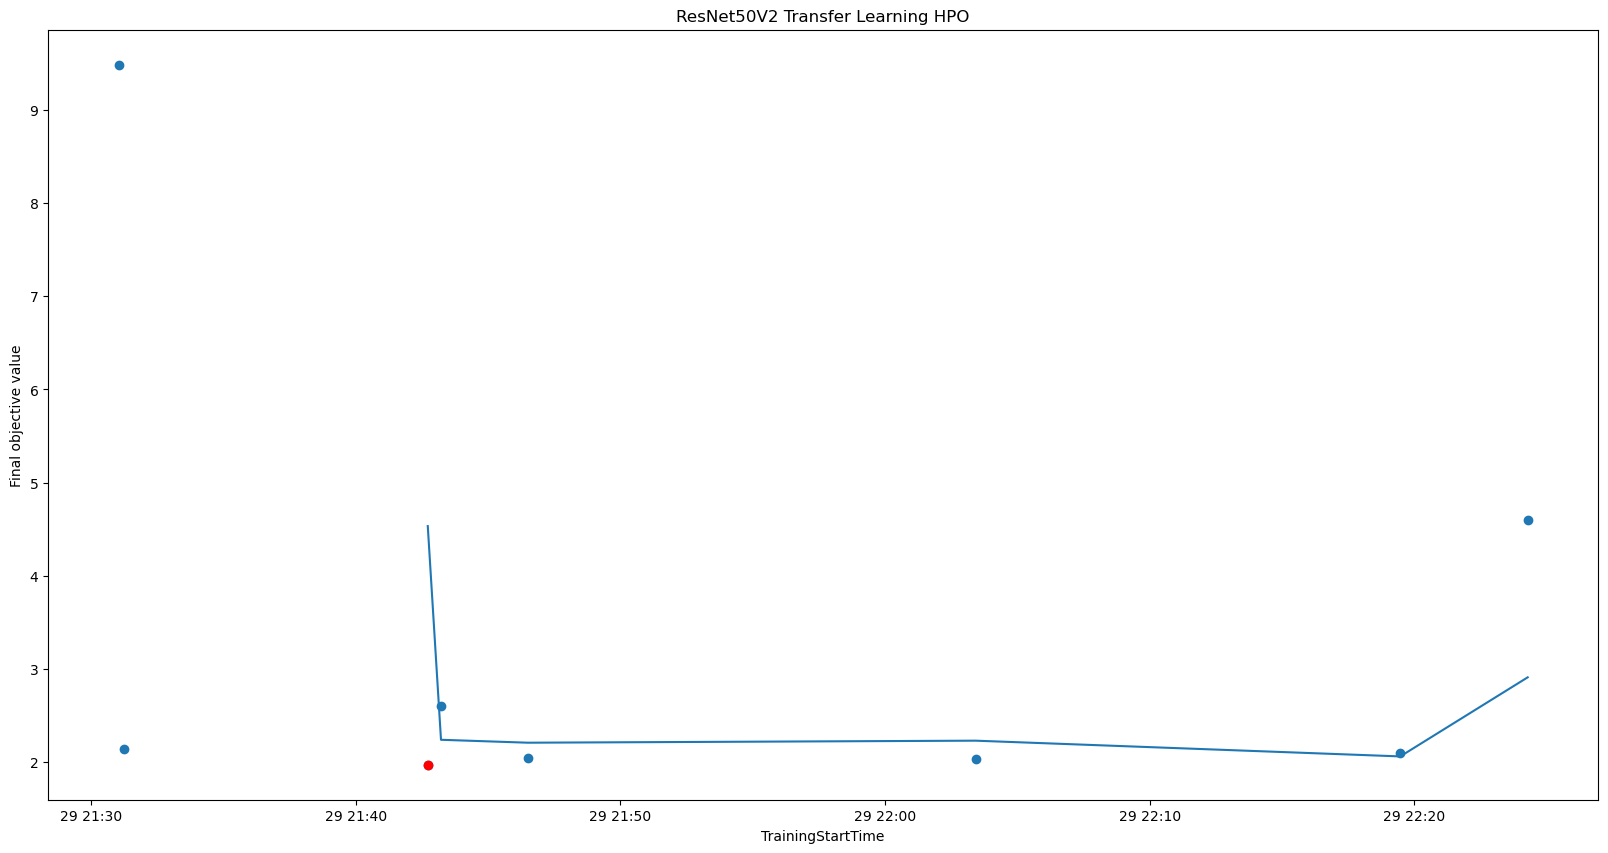

In [40]:
plt.figure(figsize=(20, 10))
# Sort by TrainingStartTime
fine_tune_hpo_results.sort_values("TrainingStartTime", inplace=True)
plt.scatter(
    fine_tune_hpo_results["TrainingStartTime"],
    fine_tune_hpo_results["FinalObjectiveValue"],
)
plt.plot(
    fine_tune_hpo_results["TrainingStartTime"],
    fine_tune_hpo_results["FinalObjectiveValue"].rolling(3).mean(),
)
# Highlight the best score in red
plt.scatter(
    fine_tune_hpo_results["TrainingStartTime"][
        fine_tune_hpo_results["FinalObjectiveValue"].idxmin()
    ],
    fine_tune_hpo_results["FinalObjectiveValue"].min(),
    c="r",
)
plt.xlabel("TrainingStartTime")
plt.ylabel("Final objective value")
plt.title("ResNet50V2 Transfer Learning HPO")
plt.show();

#### TensorBoard

In [15]:
tensorboard_log_dir = f's3://{config["s3_bucket"]}/{config["s3_key"]}/tensorboard_logs/{baseline_tuner.best_training_job()}'

!tensorboard --logdir $tensorboard_log_dir --host localhost --port 6006

2023-07-30 00:00:15.920373: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
TensorBoard 2.12.3 at http://localhost:6006/ (Press CTRL+C to quit)
^C


Loss over epochs:

<center>

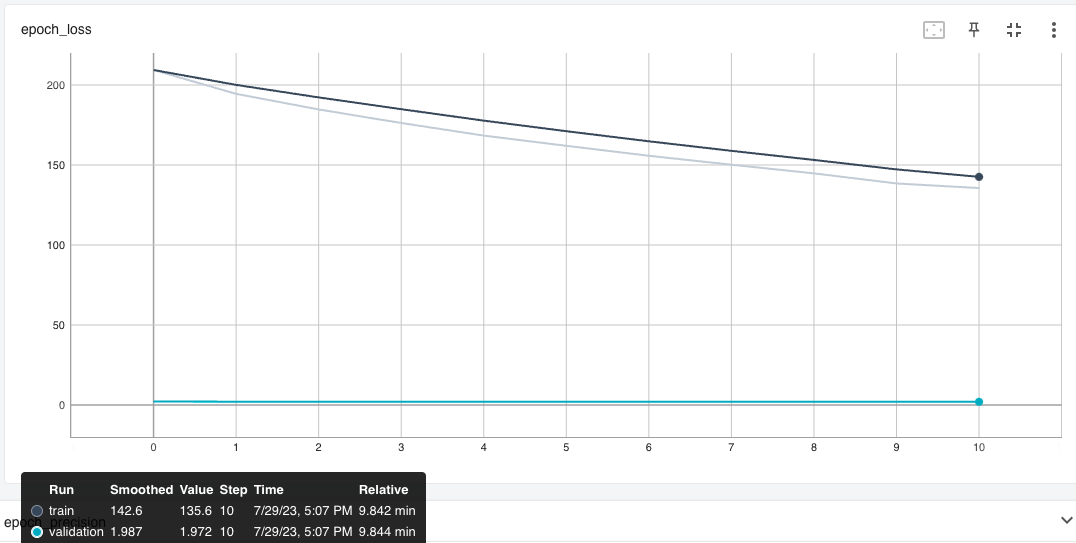

</center>

#### Inference on Test Set

In [41]:
fine_tune_model_path = fine_tune_tuner.best_estimator().model_data
fine_tune_model_path


2023-07-29 22:09:12 Starting - Preparing the instances for training
2023-07-29 22:09:12 Downloading - Downloading input data
2023-07-29 22:09:12 Training - Training image download completed. Training in progress.
2023-07-29 22:09:12 Uploading - Uploading generated training model
2023-07-29 22:09:12 Completed - Resource reused by training job: fine-tune-training-230729-2129-010-5322f0b7


's3://yang-ml-sagemaker/insect-pest-classification/models/fine-tune-training-230729-2129-006-d98de825/output/model.tar.gz'

In [5]:
!aws s3 cp $fine_tune_model_path /tmp/fine_tune_model.tar.gz
!tar -xvzf /tmp/fine_tune_model.tar.gz -C /tmp

download: s3://yang-ml-sagemaker/insect-pest-classification/models/fine-tune-training-230729-2129-006-d98de825/output/model.tar.gz to ../../../../../tmp/fine_tune_model.tar.gz
00000000/
00000000/assets/
00000000/keras_metadata.pb
00000000/saved_model.pb
00000000/fingerprint.pb
00000000/variables/
00000000/variables/variables.data-00000-of-00001
00000000/variables/variables.index


Load in model:

In [6]:
fine_tune_model = tf.keras.models.load_model("/tmp/00000000")
fine_tune_model.summary()

2023-07-29 23:12:56.221111: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 data_augmentation_layers (S  (None, 256, 256, 3)      0         
 equential)                                                      
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                             

In [8]:
fine_tune_test_metrics = fine_tune_model.evaluate(test_dataset, return_dict=True)
fine_tune_test_metrics

429/429 [==============================] - 2589s 6s/step - loss: 1.9564 - accuracy: 0.5153 - recall: 0.0000e+00 - precision: 0.0000e+00 - auc_pr: 0.0098


{'loss': 1.9564218521118164,
 'accuracy': 0.5153369903564453,
 'recall': 0.0,
 'precision': 0.0,
 'auc_pr': 0.00980374775826931}

### Comparison of Models

In [33]:
pd.concat(
    [
        pd.DataFrame.from_dict(
            data=fine_tune_test_metrics, orient="index", columns=["fine_tune"]
        ),
        pd.DataFrame.from_dict(
            data=baseline_test_metrics, orient="index", columns=["baseline"]
        ),
    ],
    axis=1,
)

,fine_tune,baseline
loss,1.956422,4.647101
accuracy,0.515337,0.014572
recall,0.000000,0.166922
precision,0.000000,0.011128
auc_pr,0.009804,0.011497


While the fine-tuned model outperforms the baseline in terms of loss and accuracy, it underperforms in terms of the recall and precision. This can be attributed to a few reasons:

* The data is imbalanced

* We used `val_loss` as the performance metric for tuning, which may not be the best option even with class weights enabled. This is where `focal_loss` can be beneficial to the optimization of the loss function; it downsamples the easy-to-classify examples and pushes to optimization to focus on the hard-to-classify examples.

Note that both the test ($\sim 1.95$) and validation ($\sim 1.99$) losses are lower than the training loss; this is because batch normalization and dropouts behave differently in training and inference modes. 